## Main Triode Class

In [1]:
import numpy as np
import pickle
from scipy.optimize import curve_fit, least_squares, root_scalar
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.interpolate import griddata, RBFInterpolator, LinearNDInterpolator
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.fft import rfft, rfftfreq
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Define Triode class
class Triode:
    def __init__(self, Vp_data, Ia_data, Vg_data, max_diss, debug=False):
        self.Vp_data = Vp_data
        self.Ia_data = Ia_data
        self.Vg_data = Vg_data
        self.max_diss = max_diss
        self.debug = debug
        
    def three_D_manifold(self):
        # Generate interpolation grid
        self.Vp_grid, self.Vg_grid = np.meshgrid(
            np.linspace(min(self.Vp_data), max(self.Vp_data), 200),
            np.linspace(min(self.Vg_data), max(self.Vg_data), 200)
        )
        grid_points = np.column_stack((self.Vp_grid.ravel(), self.Vg_grid.ravel()))

        # Fit RBF interpolator
        rbf_interp = RBFInterpolator(
            np.column_stack((self.Vp_data, self.Vg_data)),
            self.Ia_data,
            kernel = "quintic",
            smoothing = 25,
        )
        Ia_rbf = rbf_interp(grid_points)

        # Mask extrapolated values using Delaunay triangulation
        hull = Delaunay(np.column_stack((self.Vp_data, self.Vg_data)))
        mask = hull.find_simplex(grid_points) >= 0
        Ia_rbf[~mask] = np.nan  # set extrapolated values to NaN

        # Reshape to grid
        self.Ia_grid = Ia_rbf.reshape(self.Vp_grid.shape)
        
    def plot_three_D_manifold(self):
        # Step 4: Plot the surface
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.Vp_grid, self.Vg_grid, self.Ia_grid, cmap='viridis', linewidth=0, antialiased=True)
        
        ax.set_xlabel('Plate Voltage Vp (V)')
        ax.set_ylabel('Grid Voltage Vg (V)')
        ax.set_zlabel('Plate Current Ia (mA)')
        ax.set_title('Interpolated Plate Curve Surface')
        plt.tight_layout()
        plt.show()

    def load_line(self, B_plus, cathode_resist, plate_current, pk_pk, anode_resist):
        self.B_plus = B_plus
        self.anode_resist = anode_resist # defines load line
        self.cathode_resist = cathode_resist # defines op point
        self.plate_current = plate_current
        self.pk_pk = pk_pk
        self.max_current = (self.B_plus / self.anode_resist) * 1000 # b
        self.load_m = -self.max_current / self.B_plus # m
        self.Vg = -(self.plate_current / 1000) * self.cathode_resist
        
    def plot_load_line(self):
        # Plotting
        plt.figure(figsize=(10, 6))

        points_grid = np.column_stack((self.Vp_grid.ravel(), self.Vg_grid.ravel()))
        values = self.Ia_grid.ravel()
        interp = LinearNDInterpolator(points_grid, values)
        Vp_query = np.linspace(points_grid[:, 0].min(), points_grid[:, 0].max(), 500)

        # Traced from data sheet
        for Vg_target in np.unique(self.Vg_data):            
            # Create the query points at this fixed grid voltage
            query_points = np.column_stack([Vp_query, np.full_like(Vp_query, Vg_target)])
            
            # Interpolate using griddata
            Ia_interp = griddata(points_grid, values, query_points, method='linear')
            
            # Plot the result
            plt.plot(Vp_query, Ia_interp, label=f"Vg = {Vg_target}V")
                    
        # Plot load line
        y = self.load_m * Vp_query + self.max_current # y = mx + b
        plt.plot(Vp_query, y, label=f"Load Line (R_out = {int(self.anode_resist)} Ω)", color='red', linestyle='--')
        
        # Plot operating point
        pseudo_Vp_op = (self.plate_current - self.max_current) / self.load_m # y = mx + b
        plt.plot(pseudo_Vp_op, self.plate_current, color='red', marker='o', linestyle = "none", label = "Op Point")
        
        # Plot maximum dissipation
        plt.plot(Vp_query, [self.max_diss * 1000 / i for i in Vp_query], label = "Max dissipation", color='black', linestyle='--')

        # Define swing
        Vg_swing = np.linspace(self.Vg - self.pk_pk / 2, self.Vg + self.pk_pk / 2, 100)
        Vp_scan = np.linspace(self.Vp_data.min(), self.Vp_data.max(), 1000)
        
        # Bracket finder
        def find_bracket(Vg, interp, Vp_scan):
            for i in range(len(Vp_scan) - 1):
                vp1, vp2 = Vp_scan[i], Vp_scan[i + 1]
                ia1, ia2 = interp(vp1, Vg), interp(vp2, Vg)
                if None in (ia1, ia2) or np.isnan(ia1) or np.isnan(ia2):
                    continue
                res1 = ia1 - (self.B_plus - vp1) / self.anode_resist * 1e3
                res2 = ia2 - (self.B_plus - vp2) / self.anode_resist * 1e3
                if res1 * res2 < 0:
                    return vp1, vp2
            return None, None
        
        # Solve for Vp over swing
        Vp_output = []
        for Vg in Vg_swing:
            def residual(Vp):
                Ia = interp(Vp, Vg)
                if Ia is None or np.isnan(Ia):
                    return 1e6
                return Ia - (self.B_plus - Vp) / self.anode_resist * 1e3
        
            vp_lo, vp_hi = find_bracket(Vg, interp, Vp_scan)
            if vp_lo is not None:
                try:
                    sol = root_scalar(residual, bracket=[vp_lo, vp_hi], method='brentq')
                    Vp_output.append(sol.root if sol.converged else np.nan)
                except ValueError:
                    print(f"Root solve failed for Vg = {Vg:.2f}")
                    Vp_output.append(np.nan)
            else:
                print(f"No bracket found for Vg = {Vg:.2f}")
                Vp_output.append(np.nan)

        # Plot swing
        Vp_output = np.array(Vp_output)
        Ia_output = (self.B_plus - Vp_output) / self.anode_resist * 1e3
        plt.plot(Vp_output, Ia_output, "r-", label="Voltage Swing Path")
        valid = np.where(~np.isnan(Vp_output))[0]
        if len(valid) > 0:
            plt.plot(Vp_output[valid[0]], Ia_output[valid[0]], 'go', label="Swing Start")
            plt.plot(Vp_output[valid[-1]], Ia_output[valid[-1]], 'mo', label="Swing End")
        
        plt.xlabel('Plate Voltage Vp (V)')
        plt.ylabel('Plate Current Ia (mA)')
        plt.xlim([0, max(self.Vp_data) * 1.1])
        plt.ylim([0, max(self.Ia_data) * 1.1])
        plt.title('Triode Plate Curves — 12AX7')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Animate
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.Vp_grid, self.Vg_grid, self.Ia_grid, cmap='viridis', alpha=0.6)
        ax.set_xlabel("Plate Voltage Vp (V)")
        ax.set_ylabel("Grid Voltage Vg (V)")
        ax.set_zlabel("Plate Current Ia (mA)")
        ax.set_title("12AX7 Plate Curves with Animated Load Line Swing (Root Scalar, Vg fixed)")
        #ax.view_init(elev=30, azim=135)
        
        line, = ax.plot([], [], [], 'r-', linewidth=3)
        point, = ax.plot([], [], [], 'ro')
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
            return line, point
        
        def animate(i):
            line.set_data(Vp_output[:i+1], Vg_swing[:i+1])
            line.set_3d_properties(Ia_output[:i+1])
            point.set_data([Vp_output[i]], [Vg_swing[i]])
            point.set_3d_properties([Ia_output[i]])
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=len(Vg_swing), interval=50, blit=True)
        
        ani.save("triode_voltage_swing.gif", writer='pillow', fps=20)
        print("Animation saved as triode_voltage_swing.gif")
        
    def ccs_load_line(self, plate_voltage, plate_current, pk_pk, output_impede=None):
        self.plate_voltage = plate_voltage
        self.plate_current = plate_current
        self.pk_pk = pk_pk
        self.output_impede = output_impede if output_impede else 1e12  # Infinite CCS
        points_grid = np.column_stack((self.Vp_grid.ravel(), self.Vg_grid.ravel()))
        values = self.Ia_grid.ravel()
        interp = LinearNDInterpolator(points_grid, values)

        # Robust Vg solver
        def residual_vg(Vg):
            Ia = interp(self.plate_voltage, Vg)
            return 1e6 if Ia is None or np.isnan(Ia) else Ia - self.plate_current

        Vg_scan = np.linspace(min(self.Vg_data), max(self.Vg_data), 500)
        bracket_found = False
        self.Vg = None

        for i in range(len(Vg_scan) - 1):
            vg1, vg2 = Vg_scan[i], Vg_scan[i+1]
            try:
                f1, f2 = residual_vg(vg1), residual_vg(vg2)
                if np.sign(f1) != np.sign(f2):
                    sol = root_scalar(residual_vg, bracket=[vg1, vg2], method='brentq')
                    if sol.converged:
                        self.Vg = sol.root
                        bracket_found = True
                        break
            except:
                continue

        if not bracket_found:
            print("Could not find valid bracket for solving Vg. Using fallback.")
            Ia_interp_vals = np.array([interp(self.plate_voltage, vg) for vg in Vg_scan])
            diff = np.abs(Ia_interp_vals - self.plate_current)
            best_idx = np.argmin(diff)
            self.Vg = Vg_scan[best_idx]

    def plot_ccs_load_line(self):
        plt.figure(figsize=(10, 6))
        points_grid = np.column_stack((self.Vp_grid.ravel(), self.Vg_grid.ravel()))
        values = self.Ia_grid.ravel()
        interp = LinearNDInterpolator(points_grid, values)
        Vp_query = np.linspace(points_grid[:, 0].min(), points_grid[:, 0].max(), 500)

        # Traced from data sheet
        for Vg_target in np.unique(self.Vg_data):            
            # Create the query points at this fixed grid voltage
            query_points = np.column_stack([Vp_query, np.full_like(Vp_query, Vg_target)])
            
            # Interpolate using griddata
            Ia_interp = griddata(points_grid, values, query_points, method='linear')
            
            # Plot the result
            plt.plot(Vp_query, Ia_interp, label=f"Vg = {Vg_target}V")

        # Load line
        load_line = self.plate_current - Vp_query / self.output_impede
        plt.plot(Vp_query, load_line, 'r--', label=f"CCS Load Line (R_out = {int(self.output_impede)} Ω)")
        
        # Plot maximum dissipation
        plt.plot(Vp_query, [self.max_diss * 1000 / i for i in Vp_query], label = "Max dissipation", color='black', linestyle='--')

        # Voltage swing
        Vg_swing = np.linspace(self.Vg - self.pk_pk / 2, self.Vg + self.pk_pk / 2, 100)
        Vp_scan = np.linspace(min(self.Vp_data), max(self.Vp_data), 1000)
        Vp_output = []

        for Vg in Vg_swing:
            def residual(Vp):
                Ia = interp(Vp, Vg)
                return 1e6 if Ia is None or np.isnan(Ia) else Ia - (self.plate_current - Vp / self.output_impede)

            found = False
            for i in range(len(Vp_scan) - 1):
                vp1, vp2 = Vp_scan[i], Vp_scan[i + 1]
                try:
                    if np.sign(residual(vp1)) != np.sign(residual(vp2)):
                        sol = root_scalar(residual, bracket=[vp1, vp2], method='brentq')
                        if sol.converged:
                            Vp_output.append(sol.root)
                            found = True
                            break
                except:
                    continue
            if not found:
                Vp_output.append(np.nan)

        Vp_output = np.array(Vp_output)
        Ia_output = self.plate_current - Vp_output / self.output_impede

        # Plot operating point
        idx = (np.abs(Vp_output - self.plate_voltage)).argmin()
        plt.plot(self.plate_voltage, Ia_output[idx], color='red', marker='o', linestyle = "none", label = "Op Point")

        # Plot swing
        plt.plot(Vp_output, Ia_output, 'r-', label="Voltage Swing Path")
        valid = np.where(~np.isnan(Vp_output))[0]
        if len(valid) > 0:
            plt.plot(Vp_output[valid[0]], Ia_output[valid[0]], 'go', label="Swing Start")
            plt.plot(Vp_output[valid[-1]], Ia_output[valid[-1]], 'mo', label="Swing End")

        plt.title("Triode Plate Curves — 12AX7 with CCS and Finite Output Impedance")
        plt.xlabel('Plate Voltage Vp (V)')
        plt.ylabel('Plate Current Ia (mA)')
        plt.xlim([0, max(self.Vp_data) * 1.1])
        plt.ylim([0, max(self.Ia_data) * 1.1])
        
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Animate
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.Vp_grid, self.Vg_grid, self.Ia_grid, cmap='viridis', alpha=0.6)
        ax.set_xlabel("Plate Voltage Vp (V)")
        ax.set_ylabel("Grid Voltage Vg (V)")
        ax.set_zlabel("Plate Current Ia (mA)")
        ax.set_title("12AX7 Plate Curves with Animated Load Line Swing (Root Scalar, Vg fixed)")
        #ax.view_init(elev=30, azim=135)
        
        line, = ax.plot([], [], [], 'r-', linewidth=3)
        point, = ax.plot([], [], [], 'ro')
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
            return line, point
        
        def animate(i):
            #print(f"Frame {i}: Vg = {Vg_swing[i]:.2f}, Vp = {Vp_output[i]}, Ia = {Ia_output[i]}")
            line.set_data(Vp_output[:i+1], Vg_swing[:i+1])
            line.set_3d_properties(Ia_output[:i+1])
            point.set_data([Vp_output[i]], [Vg_swing[i]])
            point.set_3d_properties([Ia_output[i]])
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=len(Vg_swing), interval=50, blit=True)
        
        ani.save("triode_ccs_voltage_swing.gif", writer='pillow', fps=20)
        print("Animation saved as triode_voltage_swing.gif")

    def simulate_thd(self, Vg_op, pk_pk, CCS_current, Vp_scan=None, f=1000, cycles=3, sampling_rate=100000): # Deliberately not "self" values
        t = np.linspace(0, cycles / f, int(cycles * sampling_rate))
        Vg_in = Vg_op + (pk_pk / 2) * np.sin(2 * np.pi * f * t)
    
        if Vp_scan is None:
            Vp_scan = np.linspace(min(self.Vp_data), max(self.Vp_data), 1000)
    
        points_grid = np.column_stack((self.Vp_grid.ravel(), self.Vg_grid.ravel()))
        values = self.Ia_grid.ravel()
        interp = LinearNDInterpolator(points_grid, values)
        Vp_out = []
    
        last_vp = 150
        fallback_used = False
    
        for Vg in Vg_in:
            def residual(Vp):
                Ia = interp(Vp, Vg)
                if Ia is None or np.isnan(Ia):
                    return 1e6
                return Ia - (CCS_current - Vp / self.output_impede)
    
            found = False
            try:
                sol = root_scalar(
                    residual,
                    bracket=[last_vp - 10, last_vp + 10],
                    method='brentq'
                )
                if sol.converged:
                    last_vp = sol.root
                    Vp_out.append(sol.root)
                    found = True
            except:
                pass
    
            if not found:
                # fallback bracket
                try:
                    sol = root_scalar(residual, bracket=[0, 400], method='brentq')
                    if sol.converged:
                        last_vp = sol.root
                        Vp_out.append(sol.root)
                        fallback_used = True
                        continue
                except:
                    Vp_out.append(np.nan)
    
        Vp_out = np.array(Vp_out)
        valid = ~np.isnan(Vp_out)
    
        if fallback_used:
            print(f"⚠️ Fallback root bracket used for pk_pk={pk_pk}")
    
        if np.sum(valid) < 10:
            print(f"❌ Insufficient valid data points for pk_pk={pk_pk}")
            return np.nan, np.nan, t[valid], Vp_out[valid]
    
        t_valid = t[valid]
        Vp_valid = Vp_out[valid]
    
        yf = rfft(Vp_valid - np.mean(Vp_valid))
        freqs = rfftfreq(len(Vp_valid), 1 / sampling_rate)
    
        harmonics = np.abs(yf)
        fundamental = harmonics[1] if len(harmonics) > 1 else 1e-6
        harmonic_power = np.sum(harmonics[2:]**2)
        thd_ratio = np.sqrt(harmonic_power) / fundamental
        thd_db = 20 * np.log10(thd_ratio)
    
        # Plot only if enough points
        fig, axs = plt.subplots(2, 1, figsize=(10, 6))
        axs[0].plot(t_valid * 1000, Vp_valid)
        axs[0].set_title(f"Simulated Plate Voltage vs Time (Vg: {Vg_op:.2f}V, Pk_Pk: {pk_pk:.2f}, CCS: {CCS_current:.2f} mA)")
        axs[0].set_xlabel("Time (ms)")
        axs[0].set_ylabel("Vp (V)")
        axs[0].grid(True)
    
        axs[1].stem(freqs[:10], 20 * np.log10(harmonics[:10]))
        axs[1].set_title(f"Harmonics (THD: {thd_db:.2f} dB, Vg: {Vg_op:.2f}V, Pk_Pk: {pk_pk:.2f}, CCS: {CCS_current:.2f} mA)")
        axs[1].set_xlabel("Frequency (Hz)")
        axs[1].set_ylabel("Magnitude (dB)")
        axs[1].grid(True)
    
        plt.tight_layout()
        plt.show()
    
        return thd_ratio, thd_db, t_valid, Vp_valid
    
    def gain_and_thd_vs_swing(self, swing_range, f=1000,
                              sampling_rate=100000, fast=False):
        pk_pks = np.linspace(*swing_range)
        thd_list = []
        gain_list = []
    
        if fast:
            print("⚡ Running in FAST mode: using lower resolution and caching")
            sampling_rate = 10000
            cycles = 1.5
        else:
            cycles = 3
    
        last_vp_root = None
    
        for pk_pk in pk_pks:
            try:
                thd_ratio, thd_db, t, Vp_valid = self.simulate_thd(
                    self.Vg, pk_pk, self.plate_current, f = f, cycles = cycles, sampling_rate = sampling_rate
                )
                gain = (np.nanmax(Vp_valid) - np.nanmin(Vp_valid)) / pk_pk
                gain_list.append(gain)
                thd_list.append(thd_ratio)
            except Exception as e:
                gain_list.append(np.nan)
                thd_list.append(np.nan)
                print(f"pk_pk={pk_pk}: {e}")
    
        pk_pks = np.array(pk_pks)
        gain_list = np.array(gain_list)
        thd_list = np.array(thd_list)
    
        # Determine best linearity region
        valid = ~np.isnan(thd_list) & ~np.isnan(gain_list)
        gain_thresh = 0.1  # minimum usable gain
        idx_best = np.argmin(np.where(gain_list > gain_thresh, thd_list, np.inf))
    
        # Plot results
        fig, ax1 = plt.subplots(figsize=(10, 6))
        color = 'tab:blue'
        ax1.set_xlabel("Input Swing (V pk-pk)")
        ax1.set_ylabel("Gain (V/V)", color=color)
        ax1.plot(pk_pks, gain_list, 'o-', color=color, label="Gain")
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True)
    
        ax2 = ax1.twinx()
        color = 'tab:red'
        ax2.set_ylabel("THD (%)", color=color)
        ax2.plot(pk_pks, thd_list * 100, 's--', color=color, label="THD")
        ax2.tick_params(axis='y', labelcolor=color)
    
        if valid.any():
            ax1.axvline(pk_pks[idx_best], color='green', linestyle='--', alpha=0.7)
            ax2.axvline(pk_pks[idx_best], color='green', linestyle='--', alpha=0.7)
            ax2.annotate("Best linearity", xy=(pk_pks[idx_best], thd_list[idx_best] * 100),
                         xytext=(pk_pks[idx_best] + 0.2, thd_list[idx_best] * 100 + 2),
                         arrowprops=dict(arrowstyle='->', color='green'),
                         color='green')
    
        fig.tight_layout()
        plt.title("Gain and THD vs Input Swing (with Best Linearity)")
        plt.show()
    
        return pk_pks, gain_list, thd_list, pk_pks[idx_best], gain_list[idx_best], thd_list[idx_best]
    
    def optimize_operating_point(self,
                                  Vg_range=(-3.0, 0.0, 10),
                                  CCS_range=(0.5, 3.0, 10),
                                  gain_threshold=0.1,
                                  sampling_rate=10000,
                                  f=1000,
                                  cycles=1.5):
        Vg_vals = np.linspace(*Vg_range)
        CCS_vals = np.linspace(*CCS_range)
        
        THD_map = np.full((len(Vg_vals), len(CCS_vals)), np.nan)
        Gain_map = np.full_like(THD_map, np.nan)
    
        best_thd = np.inf
        best_params = None
    
        for i, Vg_op in enumerate(Vg_vals):
            for j, CCS_current in enumerate(CCS_vals):
                try:
                    thd, thd_db, t, vp = self.simulate_thd(
                        Vg_op, self.pk_pk, CCS_current, f = f, cycles = cycles, sampling_rate = sampling_rate
                    )
                    if np.isnan(thd) or len(vp) < 2:
                        continue
                    gain = (np.nanmax(vp) - np.nanmin(vp)) / self.pk_pk
    
                    THD_map[i, j] = thd
                    Gain_map[i, j] = gain
    
                    if gain >= gain_threshold and thd < best_thd:
                        best_thd = thd
                        best_params = (Vg_op, CCS_current, gain, thd)
    
                except Exception as e:
                    print(f"Error at Vg={Vg_op:.2f}, CCS={CCS_current:.2f}: {e}")
                    continue
    
        # Plot THD heatmap
        fig, ax = plt.subplots(figsize=(10, 6))
        im = ax.imshow(THD_map * 100, extent=[CCS_vals[0], CCS_vals[-1], Vg_vals[0], Vg_vals[-1]],
                       origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(im, ax=ax, label="THD (%)")
        ax.set_xlabel("CCS Current (mA)")
        ax.set_ylabel("Grid Bias (V)")
        ax.set_title(f"THD Heatmap (pk-pk={self.pk_pk}V)")
        
        if best_params:
            ax.plot(best_params[1], best_params[0], 'ro', label="Best")
            ax.legend()
            print(f"✅ Best Operating Point: Vg = {best_params[0]:.2f} V, CCS = {best_params[1]:.2f} mA")
            print(f"   Gain = {best_params[2]:.2f}, THD = {best_params[3]*100:.2f}%")
        else:
            print("⚠️ No valid solution found.")
    
        plt.tight_layout()
        plt.show()
        
        return best_params, Vg_vals, CCS_vals, THD_map, Gain_map

class TriodeChain:
    def __init__(self, stage1, stage2, R_out1=75000, R_out2=2000, debug=False):
        self.stage1 = stage1
        self.stage2 = stage2
        self.R_out1 = R_out1
        self.R_out2 = R_out2
        self.debug = debug
        self.stage1.three_D_manifold()
        self.stage2.three_D_manifold()
        self.interp1 = LinearNDInterpolator(
            np.column_stack((self.stage1.Vp_grid.ravel(), self.stage1.Vg_grid.ravel())),
            self.stage1.Ia_grid.ravel()
        )
        self.interp2 = LinearNDInterpolator(
            np.column_stack((stage2.Vp_grid.ravel(), stage2.Vg_grid.ravel())),
            stage2.Ia_grid.ravel()
        )

    def sweep_vk2(self, Vp1_out, CCS2_current, vk2_range=np.linspace(50, 270, 50)):
        best_vk2 = None
        most_valid = -1
        best_vp2_out = None
        debug_plotted = False  # flag to plot only once per optimize call
    
        for Vk2 in vk2_range:
            Vp2_out = []
            last_vp2 = 150
            valid_count = 0
    
            for Vp1 in Vp1_out:
                Vg2 = Vp1 - Vk2
                if not (self.stage2.Vg_data.min() <= Vg2 <= self.stage2.Vg_data.max()):
                    continue
    
                def res2(Vp):
                    Ia = self.interp2(Vp, Vg2)
                    return 1e6 if Ia is None or np.isnan(Ia) else Ia - (CCS2_current - Vp / self.R_out2)
    
                try:
                    sol2 = root_scalar(res2, bracket=[last_vp2 - 10, last_vp2 + 10], method='brentq')
                    last_vp2 = sol2.root if sol2.converged else last_vp2
                except:
                    try:
                        sol2 = root_scalar(res2, bracket=[0, 400], method='brentq')
                        last_vp2 = sol2.root if sol2.converged else last_vp2
                    except:
                        sol2 = None
                result = sol2.root if sol2 and sol2.converged else np.nan
                Vp2_out.append(result)
    
                if not np.isnan(result):
                    valid_count += 1
    
            Vp2_out = np.array(Vp2_out)
            if self.debug:
                print(f"[DEBUG] Vk2 = {Vk2:.2f}V → {valid_count} valid Vp2 solutions")
    
            if valid_count > most_valid:
                best_vk2 = Vk2
                most_valid = valid_count
                best_vp2_out = Vp2_out
    
            if valid_count == 0 and not debug_plotted:
                Vg2_test = Vp1_out[len(Vp1_out)//2] - Vk2
                Vp_vals = np.linspace(0, 400, 500)
                Ia_vals = [self.interp2(vp, Vg2_test) for vp in Vp_vals]
                Iload_vals = [CCS2_current - vp / self.R_out2 for vp in Vp_vals]

                if self.debug:
                    plt.figure(figsize=(8, 5))
                    plt.plot(Vp_vals, Ia_vals, label='Tube Ia')
                    plt.plot(Vp_vals, Iload_vals, label='Load Line')
                    plt.title(f"[DEBUG] No root — Vg2 = {Vg2_test:.2f}V, Vk2 = {Vk2:.2f}V")
                    plt.xlabel("Vp (V)")
                    plt.ylabel("Current (mA)")
                    plt.grid(True)
                    plt.legend()
                    plt.tight_layout()
                    plt.show()
                debug_plotted = True
    
        return best_vk2, best_vp2_out

    def evaluate_candidate(self, Vp1_out, Vp2_out, CCS1, Vk2, t, pk_pk1, f, sampling_rate):
        Vp1_out = np.array(Vp1_out)
        Vp2_out = np.array(Vp2_out)
    
        # if np.all(np.isnan(Vp2_out)):
        #     if self.debug:
        #         print("[Reject] All Vp2_out values are NaN.")
        #     return None
    
        # valid = ~np.isnan(Vp2_out)
        # if np.sum(valid) < 100:
        #     if self.debug:
        #         print("[Reject] Too few valid Vp2 points.")
        #     return None
    
        t_trimmed = t[:len(Vp2_out)]
        Vp_valid = Vp2_out[valid]
    
        yf = rfft(Vp_valid - np.mean(Vp_valid))
        freqs = rfftfreq(len(Vp_valid), 1 / sampling_rate)
        harmonics = np.abs(yf)
        fundamental = harmonics[1] if len(harmonics) > 1 else 1e-6
        harmonic_power = np.sum(harmonics[2:] ** 2)
        thd = np.sqrt(harmonic_power) / fundamental
        gain = (np.nanmax(Vp_valid) - np.nanmin(Vp_valid)) / pk_pk1

        # Check dissipation limits
        # Use CCS1/2 instead of interpolated Ia1 due to LTP
        Pdiss1 = np.nanmedian((CCS1 / 2 / 1000) * Vp1_out)
        Pdiss2 = np.nanmedian((self.CCS2 / 1000) * Vp2_out)
    
        # if Pdiss1 > self.stage1.max_diss or Pdiss2 > self.stage2.max_diss:
        #     if self.debug:
        #         print(f"[Reject] Pdiss1={Pdiss1:.2f}W Pdiss2={Pdiss2:.2f}W exceeds limits.")
        #     return None

        # # Check grid current limit
        # Vg2 = Vp1_out - Vk2
        # if np.nanmax(Vg2) > 1.0:
        #     if self.debug:
        #         print(f"[Reject] Vg2 excursion too high: max={np.nanmax(Vg2):.2f}V")
        #     return None

        # # Check output current
        # Rload = 600
        # Iload = Vp_valid / Rload
        # if np.nanmax(np.abs(Iload)) > 0.075:
        #     if self.debug:
        #         print(f"[Reject] Output current exceeded 75mA: Max Iout = {np.nanmax(np.abs(Iload)):.3f}A")
        #     return None
    
        margin = np.min([np.abs(Vp1 - Vk2 - self.stage2.Vg_data.min()) for Vp1 in Vp1_out if not np.isnan(Vp1)])
    
        return {
            "Gain": gain,
            "THD": thd,
            "Margin": margin,
            "Pdiss1": Pdiss1,
            "Pdiss2": Pdiss2,
            "Vp1_op": np.nanmedian(Vp1_out),
            "Vp2_op": np.nanmedian(Vp2_out)
        }

    def optimize_joint(self, pk_pk1=2.0, f=1000, sampling_rate=10000):
        Vg1_ops = np.linspace(self.stage1.Vg_data.min() + 0.5, self.stage1.Vg_data.max() - 0.5, 10)
        CCS1_vals = np.linspace(0.5, 2.0, 10)
        results = []

        with tqdm(total = len(Vg1_ops) * len(CCS1_vals), unit="parameters") as pbar:
            for Vg1_op in Vg1_ops:
                for CCS1 in CCS1_vals:
                    t = np.linspace(0, 1.5 / f, int(1.5 * sampling_rate))
                    vin_diff = pk_pk1 * np.sin(2 * np.pi * f * t)
                    Vg1_in = Vg1_op + vin_diff / 2
                    self.Vg1_in = Vg1_in
        
                    Vp1_out = []
                    last_vp = 150
        
                    for Vg1 in Vg1_in:
                        def res1(Vp):
                            Ia = self.interp1(Vp, Vg1)
                            return 1e6 if Ia is None or np.isnan(Ia) else Ia - (CCS1 / 2 - Vp / self.R_out1)
                        try:
                            sol = root_scalar(res1, bracket=[last_vp - 10, last_vp + 10], method='brentq')
                            last_vp = sol.root if sol.converged else last_vp
                        except:
                            # Fallback
                            try:
                                sol = root_scalar(res1, bracket=[0, 400], method='brentq')
                                last_vp = sol.root if sol.converged else last_vp
                            except:
                                sol = None
                        Vp1_out.append(sol.root if sol and sol.converged else np.nan)
        
                    Vp1_out = np.array(Vp1_out)
                    if np.all(np.isnan(Vp1_out)):
                        pbar.update(1)
                        continue                    
        
                    # Ia_estimates = [self.interp2(vp1, Vg) for vp1, Vg in zip(Vp1_out, Vp1_out - self.stage2.Vg_data.mean()) if not np.isnan(vp1)]
                    # CCS2 = np.nanmedian(Ia_estimates)
                    # Vk2, Vp2_out = self.sweep_vk2(Vp1_out, CCS2_current=CCS2)
                    Vk2, Vp2_out = self.sweep_vk2(Vp1_out, CCS2_current=20)
                    if Vp2_out is None or np.sum(~np.isnan(Vp2_out)) < 10:
                        pbar.update(1)
                        continue
        
                    Ia_estimates = [self.interp2(vp2, vp1 - Vk2)
                                    for vp1, vp2 in zip(Vp1_out, Vp2_out)
                                    if not np.isnan(vp1) and not np.isnan(vp2)]
                    if len(Ia_estimates) == 0:
                        pbar.update(1)
                        continue
                    CCS2 = np.nanmedian(Ia_estimates)
                    if np.isnan(CCS2) or CCS2 < 0.5 or CCS2 > 40: # Limit CCS current to above 0.5 due to non-linearity
                        pbar.update(1)
                        continue
        
                    self.CCS2 = CCS2  # set for evaluate_candidate
                    result = self.evaluate_candidate(
                        Vp1_out=Vp1_out,
                        Vp2_out=Vp2_out,
                        CCS1=CCS1,
                        Vk2=Vk2,
                        t=t,
                        pk_pk1=pk_pk1,
                        f=f,
                        sampling_rate=sampling_rate
                    )
                    if result:
                        print("SUCCESSFUL RESULT!!!!!")
                        result.update({
                            "Vg1_op": Vg1_op,
                            "CCS1": CCS1,
                            "Vk2": Vk2,
                            "CCS2": CCS2
                        })
                        results.append(result)
                    pbar.set_postfix(accepted=len(results))
                    pbar.update(1)
    
        return sorted(results, key=lambda x: x["THD"])

print("Done")

Done


## 12AX7

In [2]:
# Load CSV data
df = pd.read_csv("12AX7_plate_curves.csv")

# Flip grid voltages negative (fix)
df["Vg"] = -np.abs(df["Vg"])

Vp_data = df["Vp"].values
Vg_data = df["Vg"].values
Ia_data = df["Ia"].values

Vp_data = np.array(Vp_data)
Vg_data = np.array(Vg_data)
Ia_data = np.array(Ia_data)

triode1 = Triode(Vp_data, Ia_data, Vg_data, 1.2) # Dissipation for 12AX7
# triode1.three_D_manifold()
# triode1.plot_three_D_manifold()
# triode1.load_line(240, 1250, 1, 2, 80000) # Load line for 12AX7 plate_current in milliamps
# triode1.plot_load_line()
# triode1.ccs_load_line(135, .95, 2, 100000) # CCS load line for 12AX7
# triode1.plot_ccs_load_line()
print("Done")

Done


## 6H30

In [3]:
# Load CSV data
df = pd.read_csv("sovtek-6h30pi_plate_curves_2.csv")

# Flip grid voltages negative (fix)
df["Vg"] = -np.abs(df["Vg"])

Vp_data = df["Vp"].values
Vg_data = df["Vg"].values
Ia_data = df["Ia"].values

Vp_data = np.array(Vp_data)
Vg_data = np.array(Vg_data)
Ia_data = np.array(Ia_data)

triode2 = Triode(Vp_data, Ia_data, Vg_data, 4.0) # Dissipation for 6H30
# triode2.three_D_manifold()
# triode2.plot_three_D_manifold()
# triode2.load_line(200, 900, 10, 2, 5000) # Load line for 6H30 plate_current in milliamps
# triode2.plot_load_line()
# triode2.ccs_load_line(150, 10, 2, 1000) # CCS load line for 6H30
# triode2.plot_ccs_load_line()
print("Done")

Done


## THD Calculations

### Pk-Pk Sweep

### Vg and CCS Sweep

  1%|▋                                                                         | 1/100 [00:02<03:18,  2.01s/parameters]

[DEBUG] Vk2 = 50.00V → 0 valid Vp2 solutions


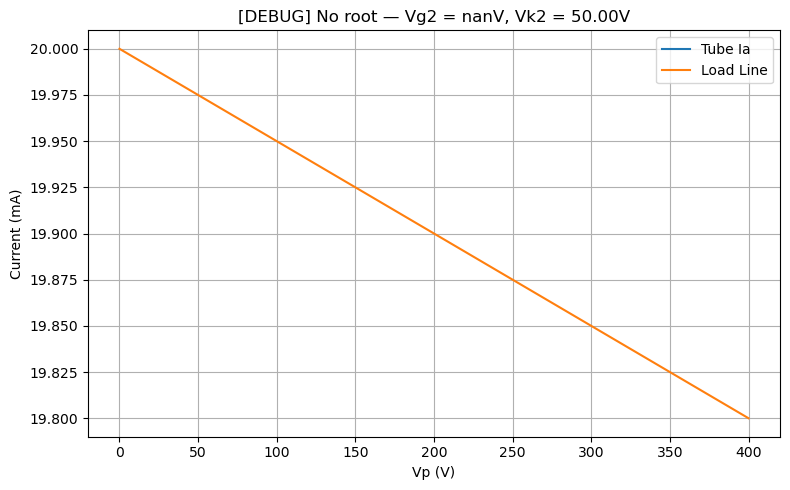

[DEBUG] Vk2 = 54.49V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 58.98V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 63.47V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 67.96V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 72.45V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 76.94V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 81.43V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 85.92V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 90.41V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 94.90V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 99.39V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 103.88V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 108.37V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 112.86V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 117.35V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 121.84V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 126.33V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 130.82V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 135.31V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 139.80V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 144.29V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 148.78V → 0 valid Vp2 solutions

  2%|█▍                                                                        | 2/100 [00:19<17:46, 10.88s/parameters]

[DEBUG] Vk2 = 265.51V → 383 valid Vp2 solutions
[DEBUG] Vk2 = 270.00V → 399 valid Vp2 solutions
[DEBUG] Vk2 = 50.00V → 0 valid Vp2 solutions


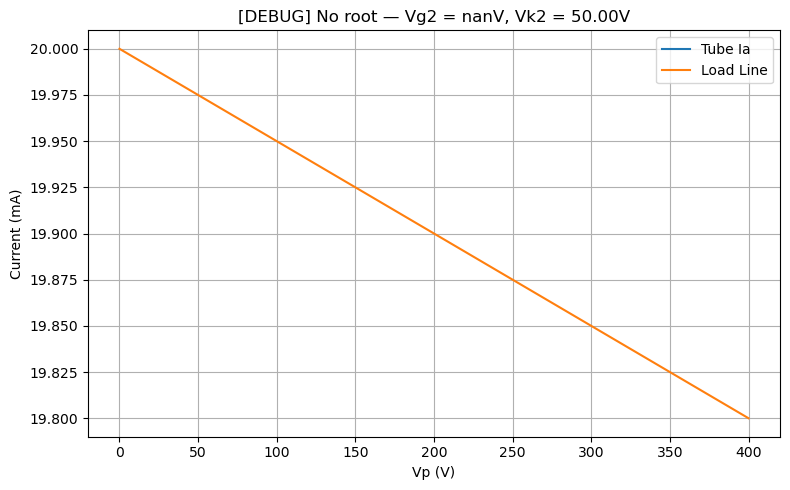

[DEBUG] Vk2 = 54.49V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 58.98V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 63.47V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 67.96V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 72.45V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 76.94V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 81.43V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 85.92V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 90.41V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 94.90V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 99.39V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 103.88V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 108.37V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 112.86V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 117.35V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 121.84V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 126.33V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 130.82V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 135.31V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 139.80V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 144.29V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 148.78V → 0 valid Vp2 solutions

  3%|██▏                                                                       | 3/100 [00:36<22:07, 13.69s/parameters]

[DEBUG] Vk2 = 265.51V → 383 valid Vp2 solutions
[DEBUG] Vk2 = 270.00V → 399 valid Vp2 solutions
[DEBUG] Vk2 = 50.00V → 0 valid Vp2 solutions


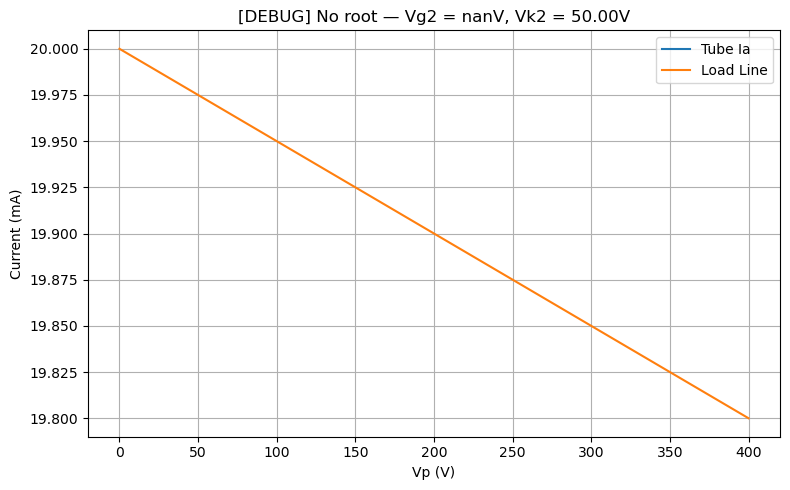

[DEBUG] Vk2 = 54.49V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 58.98V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 63.47V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 67.96V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 72.45V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 76.94V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 81.43V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 85.92V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 90.41V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 94.90V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 99.39V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 103.88V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 108.37V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 112.86V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 117.35V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 121.84V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 126.33V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 130.82V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 135.31V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 139.80V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 144.29V → 0 valid Vp2 solutions
[DEBUG] Vk2 = 148.78V → 0 valid Vp2 solutions

  4%|██▉                                                                       | 4/100 [00:52<23:25, 14.64s/parameters]

[DEBUG] Vk2 = 270.00V → 399 valid Vp2 solutions


In [ ]:
# Initialize chain
chain = TriodeChain(triode1, triode2, debug = True)

results = chain.optimize_joint()
pd.DataFrame(results).sort_values("THD").head()

## Main Pentode Class

In [ ]:
def simulate_point_with_fallback(Vg_target, Vk_target, Rout, interp, Vp_data, verbose=True):
    Vp_range = np.linspace(min(Vp_data), max(Vp_data), 500)
    Ia_interp = np.array([interp(vp, Vg_target) for vp in Vp_range])
    Ia_load = np.array([(Vk_target - vp) / Rout * 1e3 for vp in Vp_range])  # mA
    residual = Ia_interp - Ia_load

    # Bracket root
    for i in range(len(Vp_range) - 1):
        res1 = residual[i]
        res2 = residual[i + 1]
        if not np.isnan(res1) and not np.isnan(res2) and res1 * res2 < 0:
            try:
                sol = root_scalar(
                    lambda Vp: interp(Vp, Vg_target) - (Vk_target - Vp) / Rout * 1e3,
                    bracket=[Vp_range[i], Vp_range[i + 1]],
                    method='brentq'
                )
                if sol.converged:
                    if verbose:
                        print(f"✅ Root found at Vp = {sol.root:.2f}V")
                    return sol.root
            except Exception as e:
                if verbose:
                    print(f"⚠️ Root solve failed: {e}")
                break

    # If we get here, try fallback to closest point
    try:
        idx = np.nanargmin(np.abs(residual))
        fallback_vp = Vp_range[idx]
        if verbose:
            print(f"⚠️ No root — fallback to closest match: Vp ≈ {fallback_vp:.2f}V (Residual = {residual[idx]:.4f})")
        return fallback_vp
    except:
        if verbose:
            print("❌ Fallback root failed.")
        return np.nan